In [1]:
import numpy as np
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from Models import ConvEncoder, ConvDecoder, mlpEncoder, mlpDecoder, TrAE, Classifier, TrLSTM, TrLinear
from Dataset import data_provider, Trajectory2Dset

from torch.utils.data import DataLoader

import time
import copy

Need to code for evaluating using accuracy, F1 score, AUROC, AUPRC of classification, and loss value of AE

In [2]:
import easydict

args = easydict.EasyDict({
    'is_training': 1,
    'model': 'A', # ['A', 'B']
    ### data loader
    'root_path': './Data/',
    'data': '2D/', # ['2D', '3D/old/', '3D/new/']
    'data_path': 'csv/',
    'data_type': 'normal', # ['noraml', 'mixed']
    'checkpoints': './checkpoints/',
    'Nsamples': 500, 
    'ratio': [7,1,2],
    ### forecasting task
    'seq_len': 3200, # [2144, 4576, 2656] # 3200 in paper
    'label_len': 100,
    'pred_len': 100,
    'class_num': 5,
    'individual': False,
    ### transformer
    'layer_num': 1,
    'dropout': 0.1,
    'max_len': 5000,
    'd_model': 512,
    'd_h': 8,
    'd_ff': 2048,
    ### Layers
    'layer_num': 5,
    'input_channel': 23,    # 2 in paper
    't': 128,               # 16 in paper
    'output_channel': 23,   # 4 in paper
    'do_predict': True,
    ### optimization
    'num_workers': 8,
    'itr': 1,
    'train_epochs': 2000,   # 1000 in paper
    'batch_size': 64,       # 64 in paper
    'patience': 3,
    'lr': 0.005,
    ### GPU
    'device': 'cuda:0',
    'use_gpu': True,
    'multi_gpu': True,
})

args.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if args.data == '2D/':
    args.data_path = ''
    args.seq_len = 3200  # 3200 in paper
    args.class_num = 4
    args.input_channel = 2
    args.t = 16
    args.output_channel = 4
    args.ratio = [3,1,1]
elif args.data == '3D/old/':
    args.data_path = ''
    args.seq_len = 4576
    args.input_channel = 3
    args.t = 64
    args.output_channel = 8
elif args.data == '3D/new/':
    args.input_channel = 3 # [3, 3, 3, 3, 3, 4, 4]
    args.seq_len = 3200  # 3200 in paper
    args.t = 16

if args.model == 'B':
    args.seq_len = 400
print(args.device)

cuda:0


## Data Preprocessing

### 2-Dimensional Trajectory

원본 .pickle 로드 및 전처리 후 .npy 저장

In [2]:
import pickle
'''
Trajectory types: Normal, autopilot_lag, LOSrate_bias, LOSrate_delay
Target distance = uniform(4500, 5500)
states = [x, y, vm, path_angle] + 1 control input, 5 states
label = 0, 1, 2, 3 for normal, autopilot_lag, LOSrate_bias, LOSrate_delay respectively, 4 classes
minimum length of trajectory = 1360 (1360*0.01 = 13.6 seconds)
maximum length of trajectory = 2131 (2131*0.01 = 21.31 seconds)
fixed sequence length = 2144 (2144*0.01 = 21.44 seconds)
'''
start = time.time()
with open('Data/2D/Trajectories.pickle', 'rb') as f:
    Dataset = pickle.load(f)

# normal = Dataset['normal_PNG']
# lag = Dataset['autopilot_lag']
# bias = Dataset['LOSrate_bias']
# delay = Dataset['LOSrate_delay']
seq_len = 2144

label = 0
x = []
y = []
for tr_type in Dataset:
    states = Dataset[tr_type]['states']
    inputs = Dataset[tr_type]['actions']
    for i in range(len(states)):
        tr = np.concatenate((states[i], np.insert(inputs[i], 0, 0).reshape(-1 ,1)), axis=1)
        terminal = tr[-1].copy()
        terminal[2]=terminal[4]=0
        tr = np.concatenate((tr, np.tile(terminal, (seq_len-len(tr), 1))), axis=0)
        x.append(tr)
        y.append(label)
    label += 1
x = np.array(x)
y = np.array(y).reshape(-1, 1)
np.save('Data/2D/x.npy', x)
np.save('Data/2D/y.npy', y)
# x = np.load('Data/2D/x.npy')
# y = np.load('Data/2D/y.npy')
x.shape, y.shape, time.time()-start

((2000, 2144, 5), (2000, 1), 0.24863266944885254)

.npy 로드

In [43]:
x = np.load('Data/2D/x.npy')
y = np.load('Data/2D/y.npy')
x.shape, y.shape, time.time()-start

((2000, 2144, 5), (2000, 1), 4.354981899261475)

### 3-Dimentional Trajectory old version

원본 .pickle 로드 및 전처리 후 .npy 저장

In [5]:
'''
Trajectory types: Normal, Burn time, Xcp position, Thrust Tilt Angle, Fin bias
Target Distance = 4000
States = ['Accm_1', 'Accm_2', 'Accm_3', 'angEuler_1', 'angEuler_2', 'angEuler_3', 'Rmi_1', 'Rmi_2', 'Rmi_3', 'Vmi_1', 'Vmi_2', 'Vmi_3', 'Accm_Cmd_1', 'Accm_Cmd_2', 'Accm_Cmd_3', 'PhiCmd'], 16 states
label = [0, 1, 2, 3, 4] for normal, burn_time, xcp_pos, thrust_tilt, fin_bias respectively, 5 classes
minimum length of trajectory = 412 (412*0.01 = 4.12 seconds)
maximum length of trajectory = 4569 (4569*0.01 = 45.69 seconds)
fixed sequence length = 4576 (4576*0.01 = 45.76 seconds)
'''
start = time.time()
seq_len = 4576
x = []
y = []

for i, tr_type in enumerate(['Normal', 'Burntime', 'Xcpposition', "ThrustTiltAngle", 'Finbias']):
    gid = pd.read_excel(f'Data/3D/old/Gid_{i+1}.xlsx', sheet_name=None)
    msl = pd.read_excel(f'Data/3D/old/Msl_{i+1}.xlsx', sheet_name=None)
    
    for sheet in gid:
        tr = pd.merge(msl[sheet][['Time', 'Rmi_1', 'Rmi_2', 'Rmi_3', 'Vmi_1', 'Vmi_2', 'Vmi_3', 'Accm_1', 'Accm_2', 'Accm_3', 'angEuler_1', 'angEuler_2', 'angEuler_3']], gid[sheet][['Time', 'Accm_Cmd_1', 'Accm_Cmd_2', 'Accm_Cmd_3', 'Phi_Cmd']]).to_numpy()[:, 1:]
        terminal = tr[-1].copy()
        terminal[3]=terminal[4]=terminal[5]=terminal[6]=terminal[7]=terminal[8]=terminal[12]=terminal[13]=terminal[14]=terminal[15]=0
        tr = np.concatenate((tr, np.tile(terminal, (seq_len-len(tr), 1))), axis=0)
        if sheet == 'Sheet1' and tr_type == 'Normal':
            x = [tr for _ in range(140)]
            y = [i for _ in range(140)]
        else:
            x.append(tr)
            y.append(i)

x = np.array(x)
y = np.array(y).reshape(-1, 1)
np.save('Data/3D/x_old.npy', x)
np.save('Data/3D/y_old.npy', y)
# x = np.load('Data/3D/x_old.npy')
# y = np.load('Data/3D/y_old.npy')
x.shape, y.shape, time.time()-start

((700, 4576, 16), (700, 1), 438.2133049964905)

.npy 로드

In [42]:
start = time.time()
x = np.load('Data/3D/x_old.npy')
y = np.load('Data/3D/y_old.npy')
x.shape, y.shape, time.time()-start

((700, 4576, 16), (700, 1), 0.07254505157470703)

### 3-Dimensional Trajectory new version

원본 .pickle 로드 및 전처리 후 .npy 저장

In [128]:
'''
Trajectory types: Normal, Burn time, Xcp position, Thrust Tilt Angle, Fin bias
Target Distance = 4000
Total states = ['Rmi_1', 'Rmi_2', 'Rmi_3', 'Vmi_1', 'Vmi_2', 'Vmi_3', 'Wmb_1', 'Wmb_2', 'Wmb_3', 'Accm_1', 'Accm_2', 'Accm_3', 'angEuler_1', 'angEuler_2', 'angEuler_3', 'FinOut_1', 'FinOut_2', 'FinOut_3', 'FinOut_4', 'err_FinBias_1', 'err_FinBias_2', 'err_FinBias_3', 'err_FinBias_4', 'FinCmd_1', 'FinCmd_2', 'FinCmd_3', 'FinCmd_4', 'err_BurnTime', 'err_Tilt_1', 'err_Tilt_2', 'err_delXcp'], 31 states
Used States = ['Rmi_1', 'Rmi_2', 'Rmi_3', 'Vmi_1', 'Vmi_2', 'Vmi_3', 'Wmb_1', 'Wmb_2', 'Wmb_3', 'Accm_1', 'Accm_2', 'Accm_3', 'angEuler_1', 'angEuler_2', 'angEuler_3', 'FinOut_1', 'FinOut_2', 'FinOut_3', 'FinOut_4', 'FinCmd_1', 'FinCmd_2', 'FinCmd_3', 'FinCmd_4'], 23 states
label = [0, 1, 2, 3, 4] for normal, burn_time, xcp_pos, thrust_tilt, fin_bias respectively, 5 classes
minimum length of trajectory = 2449 (2448*0.01 = 24.48 seconds)
maximum length of trajectory = 2635 (2635*0.01 = 26.35 seconds)
fixed sequence length = 2656 (2656*0.01 = 26.56 seconds)
'''
start = time.time()
seq_len = 2656
x = []
y = []
tr = {}
for i, tr_type in enumerate(['Normal', 'Burntime', 'Xcpposition', "ThrustTiltAngle", 'Finbias']):
    N = 1 if i == 0 else 500
    for tr_i in range(N):
        tr = pd.read_csv(f'Data/3D/new/csv/Type_{i+1}_{tr_i+1}.csv', header=None)
        tr.columns = ['Rmi_1', 'Rmi_2', 'Rmi_3', 'Vmi_1', 'Vmi_2', 'Vmi_3', 'Wmb_1', 'Wmb_2', 'Wmb_3', 'Accm_1', 'Accm_2', 'Accm_3', 'angEuler_1', 'angEuler_2', 'angEuler_3', 'FinOut_1', 'FinOut_2', 'FinOut_3', 'FinOut_4', 'err_FinBias_1', 'err_FinBias_2', 'err_FinBias_3', 'err_FinBias_4', 'FinCmd_1', 'FinCmd_2', 'FinCmd_3', 'FinCmd_4', 'err_BurnTime', 'err_Tilt_1', 'err_Tilt_2', 'err_delXcp']
        tr = tr[['Rmi_1', 'Rmi_2', 'Rmi_3', 'Vmi_1', 'Vmi_2', 'Vmi_3', 'Wmb_1', 'Wmb_2', 'Wmb_3', 'Accm_1', 'Accm_2', 'Accm_3', 'angEuler_1', 'angEuler_2', 'angEuler_3', 'FinOut_1', 'FinOut_2', 'FinOut_3', 'FinOut_4', 'FinCmd_1', 'FinCmd_2', 'FinCmd_3', 'FinCmd_4']].to_numpy()
        tr[0] = 4000 - tr[0]
        terminal = tr[-1].copy()
        terminal[3]=terminal[4]=terminal[5]=terminal[6]=terminal[7]=terminal[8]=terminal[12]=terminal[13]=terminal[14]=terminal[19]=terminal[20]=terminal[21]=terminal[22]=0
        tr = np.concatenate((tr, np.tile(terminal, (seq_len-len(tr), 1))), axis=0)
        if i == 0:
            x = [tr for _ in range(500)]
            y = [i for _ in range(500)]
        else:
            x.append(tr)
            y.append(i)

x = np.array(x)
y = np.array(y).reshape(-1, 1)
np.save('Data/3D/x_new.npy', x)
np.save('Data/3D/y_new.npy', y)
# x = np.load('Data/3D/x_new.npy')
# y = np.load('Data/3D/y_new.npy')
x.shape, y.shape, time.time()-start

((2500, 2656, 23), (2500, 1), 16.053280115127563)

.npy 로드

In [6]:
start = time.time()
x = np.load('Data/3D/x_new.npy')
y = np.load('Data/3D/y_new.npy')
x.shape, y.shape, time.time()-start

((2500, 2656, 23), (2500, 1), 0.24094510078430176)

## Dataset and Network Load

In [3]:
train_set, train_loader = data_provider(args, 'train')
train_c_set, train_c_loader = data_provider(args, 'train_c')
valid_set, valid_loader = data_provider(args, 'valid')
test_set, test_loader = data_provider(args, 'test')
total_set, total_loader = data_provider(args, 'pred')
# next(iter(train_loader))[0].shape, next(iter(train_loader))[1].shape, len(train_loader), train_set.data_x.shape, train_set.data_y.shape
# next(iter(valid_loader))[0].shape, next(iter(valid_loader))[1].shape, len(valid_loader), valid_set.data_x.shape, valid_set.data_y.shape
# next(iter(test_loader))[0].shape, next(iter(test_loader))[1].shape, len(test_loader), test_set.data_x.shape, test_set.data_y.shape

In [34]:
model = TrAE(ConvEncoder, ConvDecoder, args).to(args.device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=args.lr)

## Training Script

In [4]:
def AE_train(model, dataloaders, criterion, optimizer, num_epochs=10, channels = 2, channel_type = None):
    """
    model: model to train
    dataloaders: train, val, test data's loader
    criterion: loss function
    optimizer: optimizer to update your model
    """
    since = time.time()

    train_loss_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = 100000000
    
    if channel_type == None:
        cl = 0
    elif channel_type == 'Rmi':
        cl = 0
    elif channel_type == 'Vmi':
        cl = 3
    elif channel_type == 'Wmb':
        cl = 6
    elif channel_type == 'Accm':
        cl = 9
    elif channel_type == 'ang':
        cl = 12
    elif channel_type == 'Fout':
        cl = 15
    elif channel_type == 'Fcmd':
        cl = 19
    cr = cl + channels

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()            # Set model to training mode
            else:
                model.eval()            # Set model to evaluate mode

            running_loss = 0.0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(args.device)[:,:,cl:cr].type(torch.float32).transpose(1, 2)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):

                    outputs, encoded = model(inputs)
                    loss = criterion(outputs, inputs)   
                    
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item()        
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            print('{} Loss: {:.4f}'.format(phase, epoch_loss))
            
            # deep copy the model
            if phase == 'train':
                train_loss_history.append(epoch_loss)
            if phase == 'val':
                val_loss_history.append(epoch_loss)
            if phase == 'val' and epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_val_loss))

    # load best model weights
    # model.load_state_dict(best_model_wts)
    return model, best_model_wts, train_loss_history, val_loss_history

Epoch 1/1000
----------
train Loss: 115654.4000
val Loss: 104900.9413

Epoch 2/1000
----------
train Loss: 39626.1866
val Loss: 89533.8837

Epoch 3/1000
----------
train Loss: 4395.8451
val Loss: 9051.5105

Epoch 4/1000
----------
train Loss: 1712.5054
val Loss: 2440.2448

Epoch 5/1000
----------
train Loss: 1384.3184
val Loss: 1592.4000

Epoch 6/1000
----------
train Loss: 1290.1875
val Loss: 1478.2727

Epoch 7/1000
----------
train Loss: 1250.5116
val Loss: 1472.1470

Epoch 8/1000
----------
train Loss: 1211.2242
val Loss: 1332.7149

Epoch 9/1000
----------
train Loss: 1164.0927
val Loss: 1289.6269

Epoch 10/1000
----------
train Loss: 1122.0343
val Loss: 1218.0771

Epoch 11/1000
----------
train Loss: 1088.5536
val Loss: 1172.0240

Epoch 12/1000
----------
train Loss: 1061.0233
val Loss: 1183.6876

Epoch 13/1000
----------
train Loss: 1035.6090
val Loss: 1173.5838

Epoch 14/1000
----------
train Loss: 999.7187
val Loss: 1080.8990

Epoch 15/1000
----------
train Loss: 977.0312
val Lo

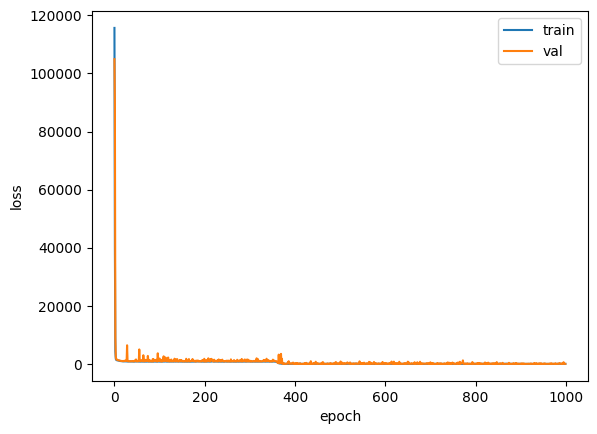

Epoch 1/1000
----------
train Loss: 120837.4471
val Loss: 118681.8200

Epoch 2/1000
----------
train Loss: 58308.4567
val Loss: 45345.5575

Epoch 3/1000
----------
train Loss: 8263.0048
val Loss: 32409.0547

Epoch 4/1000
----------
train Loss: 2000.3817
val Loss: 2967.8262

Epoch 5/1000
----------
train Loss: 1375.8473
val Loss: 1519.9564

Epoch 6/1000
----------
train Loss: 1233.0832
val Loss: 1436.7313

Epoch 7/1000
----------
train Loss: 1182.1460
val Loss: 1375.8347

Epoch 8/1000
----------
train Loss: 1146.0200
val Loss: 1325.2719

Epoch 9/1000
----------
train Loss: 1104.2931
val Loss: 1274.2921

Epoch 10/1000
----------
train Loss: 1067.7480
val Loss: 1255.6732

Epoch 11/1000
----------
train Loss: 1031.1618
val Loss: 1217.6536

Epoch 12/1000
----------
train Loss: 996.6762
val Loss: 1177.2705

Epoch 13/1000
----------
train Loss: 964.7393
val Loss: 1144.5152

Epoch 14/1000
----------
train Loss: 930.8439
val Loss: 1092.2935

Epoch 15/1000
----------
train Loss: 900.4624
val Los

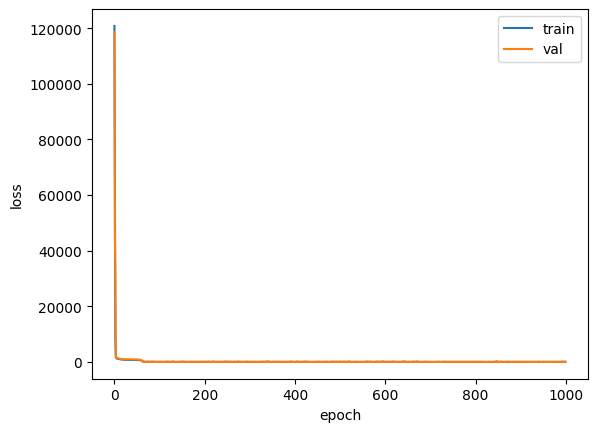

In [5]:
for dataT in ['mixed', 'normal']:
    args.data_type = dataT
    train_set, train_loader = data_provider(args, 'train')
    train_c_set, train_c_loader = data_provider(args, 'train_c')
    valid_set, valid_loader = data_provider(args, 'valid')
    test_set, test_loader = data_provider(args, 'test')
    total_set, total_loader = data_provider(args, 'pred')
    
    if args.data == '3D/new':
        for chT in ['Rmi', 'Vmi', 'Wmi', 'Accm', 'Ang', 'Fout', 'Fcmd']:
            ch = {'Rmi':3, 'Vmi':3, 'Wmi':3, 'Accm':3, 'Ang':3, 'Fout':4, 'Fcmd':4}
            args.input_channel = ch[chT]
            model = TrAE(ConvEncoder, ConvDecoder, args).to(args.device)
            criterion = nn.MSELoss()
            optimizer = optim.Adam(model.parameters(), lr=args.lr)

            data_loaders = {'train': train_loader, 'val': valid_loader, 'test': test_loader}
            trained_model, best_model_wts, train_loss_history, val_loss_history = AE_train(model, data_loaders, criterion, optimizer, num_epochs=args.train_epochs, channels = args.input_channel, channel_type = chT)
            torch.save(trained_model.state_dict(), args.checkpoints+args.model+'_'+args.data_type+'_'+chT+'_model.pth')
            torch.save(trained_model.encoder.state_dict(), args.checkpoints+args.model+'_'+args.data_type+'_'+chT+'_model_e.pth')
            trained_model.load_state_dict(best_model_wts)
            torch.save(trained_model.state_dict(), args.checkpoints+args.model+'_'+args.data_type+'_'+chT+'_best_model.pth')
            torch.save(trained_model.encoder.state_dict(), args.checkpoints+args.model+'_'+args.data_type+'_'+chT+'_best_model_e.pth')
            print('model saved to %s' % args.checkpoints+args.model+'_'+args.data_type+'_'+chT+'_model')
            
            plt.plot(train_loss_history, label='train')
            plt.plot(val_loss_history, label='val')
            plt.xlabel('epoch')
            plt.ylabel('loss')
            plt.legend()
            plt.show()
    else:
        model = TrAE(ConvEncoder, ConvDecoder, args).to(args.device)
        criterion = nn.MSELoss()
        optimizer = optim.Adam(model.parameters(), lr=args.lr)

        data_loaders = {'train': train_loader, 'val': valid_loader, 'test': test_loader}
        trained_model, best_model_wts, train_loss_history, val_loss_history = AE_train(model, data_loaders, criterion, optimizer, num_epochs=args.train_epochs, channels = args.input_channel)
        torch.save(trained_model.state_dict(), args.checkpoints+args.model+'_'+args.data_type+'_model.pth')
        torch.save(trained_model.encoder.state_dict(), args.checkpoints+args.model+'_'+args.data_type+'_model_e.pth')
        trained_model.load_state_dict(best_model_wts)
        torch.save(trained_model.state_dict(), args.checkpoints+args.model+'_'+args.data_type+'_best_model.pth')
        torch.save(trained_model.encoder.state_dict(), args.checkpoints+args.model+'_'+args.data_type+'_best_model_e.pth')
        print('model saved to %s' % args.checkpoints+args.model+'_'+args.data_type+'_model')
        
        plt.plot(train_loss_history, label='train')
        plt.plot(val_loss_history, label='val')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.legend()
        plt.show()

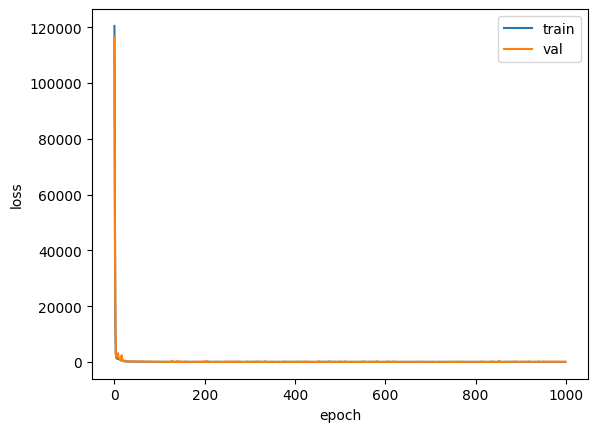

In [37]:
# Let's draw a learning curve like below.
plt.plot(train_loss_history, label='train')
plt.plot(val_loss_history, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

## Test Script

In [38]:
with torch.no_grad():
    running_loss = 0.0
    for inputs, labels in data_loaders["test"]:
        inputs = inputs.to(args.device)[:,:,:2].type(torch.float32).transpose(1, 2)

        outputs, encoded = trained_model(inputs)
        test_loss = criterion(outputs, inputs)
        
        running_loss += test_loss.item() * inputs.size(0)

    test_loss = running_loss / len(data_loaders["test"].dataset)
    print(test_loss)

299.7319561767578


## Trajectory Visualizing

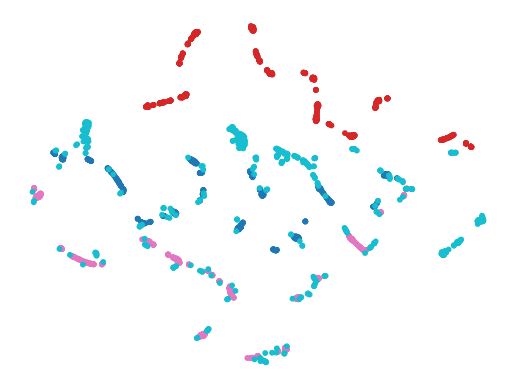

In [39]:
np.random.seed(42)

from sklearn.manifold import TSNE

dataset_array = total_set.data_x / 255
dataset_array = np.float32(dataset_array)
labels = total_set.data_y

dataset_array = torch.tensor(dataset_array)
inputs = dataset_array.to(args.device)[:,:,:2].type(torch.float32).transpose(1, 2)
outputs, encoded = trained_model(inputs)

encoded = encoded.cpu().detach().numpy().reshape(encoded.size(0), -1)
tsne = TSNE()   
X_test_2D = tsne.fit_transform(encoded)
X_test_2D = (X_test_2D - X_test_2D.min()) / (X_test_2D.max() - X_test_2D.min())

plt.scatter(X_test_2D[:, 0], X_test_2D[:, 1], c=labels, s=10, cmap="tab10")
plt.axis("off")
plt.show()

In [57]:
encoder = ConvEncoder(args.input_channel, args.t, args.output_channel)
encoder.load_state_dict(torch.load(args.checkpoints+f'{args.model}_{args.data_type}_model_e.pth'))
encoder = encoder.to(args.device)
classifier = Classifier(args.seq_len//(2**args.layer_num)*args.class_num, args.class_num).to(args.device)
classifier_lossf = nn.MSELoss()
# classifier_lossf = nn.CrossEntropyLoss()
classifier_optim = optim.Adam(classifier.parameters(), lr=args.lr)

In [6]:
def AC_train(encoder, classifier, dataloaders, criterion, optimizer, num_epochs=10, channels = 2, channel_type = None):
    """
    model: model to train
    dataloaders: train, val, test data's loader
    criterion: loss function
    optimizer: optimizer to update your model
    """
    since = time.time()

    train_loss_history = []
    val_loss_history = []

    best_model_wts = copy.deepcopy(classifier.state_dict())
    best_val_loss = 100000000
    
    if channel_type == None:
        cl = 0
    elif channel_type == 'Rmi':
        cl = 0
    elif channel_type == 'Vmi':
        cl = 3
    elif channel_type == 'Wmb':
        cl = 6
    elif channel_type == 'Accm':
        cl = 9
    elif channel_type == 'ang':
        cl = 12
    elif channel_type == 'Fout':
        cl = 15
    elif channel_type == 'Fcmd':
        cl = 19
    cr = cl + channels

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-' * 10)

        for phase in ['train', 'val']:
            encoder.eval()
            if phase == 'train':
                classifier.train()            # Set model to training mode
            else:
                classifier.eval()            # Set model to evaluate mode

            running_loss = 0.0
            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(args.device)[:,:,cl:cr].type(torch.float32).transpose(1, 2)
                labels = F.one_hot(labels, num_classes=4).to(args.device).type(torch.float32)
                optimizer.zero_grad()
                
                with torch.no_grad():
                    hidden = encoder(inputs)
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = classifier(hidden.reshape(hidden.size(0), -1)).type(torch.float32)
                    # print(outputs.shape, labels.shape)
                    # loss = criterion(outputs.view(-1), labels.view(-1))
                    loss = criterion(outputs, labels)
                    
                    if phase == 'train':
                        # loss.requires_grad = True
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item()        
            epoch_loss = running_loss #/ len(dataloaders[phase].dataset)
            print('{} Loss: {:.4f}'.format(phase, epoch_loss))
            
            # deep copy the model
            if phase == 'train':
                train_loss_history.append(epoch_loss)
            if phase == 'val':
                val_loss_history.append(epoch_loss)
            if phase == 'val' and epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                best_model_wts = copy.deepcopy(classifier.state_dict())
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Loss: {:4f}'.format(best_val_loss))

    # load best model weights
    # classifier.load_state_dict(best_model_wts)
    return classifier, best_model_wts, train_loss_history, val_loss_history

In [10]:
for dataT in ['mixed', 'normal']:
    if dataT == 'mixed':
        continue
    args.data_type = dataT
    
    train_set, train_loader = data_provider(args, 'train')
    train_c_set, train_c_loader = data_provider(args, 'train_c')
    valid_set, valid_loader = data_provider(args, 'valid')
    test_set, test_loader = data_provider(args, 'test')
    total_set, total_loader = data_provider(args, 'pred')
    
    if args.data == '3D/new':
        for chT in ['Rmi', 'Vmi', 'Wmi', 'Accm', 'Ang', 'Fout', 'Fcmd']:
            ch = {'Rmi':3, 'Vmi':3, 'Wmi':3, 'Accm':3, 'Ang':3, 'Fout':4, 'Fcmd':4}
            args.input_channel = ch[chT]
    
            for lossf in ['MSE', 'CE']:
                if lossf == 'MSE':
                    classifier_lossf = nn.MSELoss()
                elif lossf == 'CE':
                    classifier_lossf = nn.CrossEntropyLoss()
                encoder = ConvEncoder(args.input_channel, args.t, args.output_channel)
                encoder.load_state_dict(torch.load(args.checkpoints+f'{args.model}_{args.data_type}_{chT}_model_e.pth'))
                encoder = encoder.to(args.device)
                classifier = Classifier(args.seq_len//(2**args.layer_num)*args.class_num, args.class_num).to(args.device)
                classifier_optim = optim.Adam(classifier.parameters(), lr=args.lr)

                data_loaders = {'train': train_c_loader, 'val': valid_loader, 'test': test_loader}
                trained_classifier, best_classifier_wts, train_loss_history, val_loss_history = AC_train(encoder, classifier, data_loaders, classifier_lossf, classifier_optim, num_epochs=args.train_epochs, channels=args.input_channel, channel_type=chT)
                torch.save(trained_classifier.state_dict(), args.checkpoints+lossf+'_3L_'+args.model+'_'+args.data_type+'_'+chT+'_model_c.pth')
                torch.save(best_classifier_wts, args.checkpoints+lossf+'_3L_'+args.model+'_'+args.data_type+'_'+chT+'_best_model_c.pth')
                print('model saved to %s' % args.checkpoints+lossf+'_3L_'+args.model+'_'+args.data_type+'_'+chT+'_model_c')
                
                # Let's draw a learning curve like below.
                plt.plot(train_loss_history, label='train')
                plt.plot(val_loss_history, label='val')
                plt.xlabel('epoch')
                plt.ylabel('loss')
                plt.legend()
                plt.show() 
    else:
        for lossf in ['MSE', 'CE']:
            if lossf == 'MSE':
                classifier_lossf = nn.MSELoss()
            elif lossf == 'CE':
                classifier_lossf = nn.CrossEntropyLoss()
            encoder = ConvEncoder(args.input_channel, args.t, args.output_channel)
            encoder.load_state_dict(torch.load(args.checkpoints+f'{args.model}_{args.data_type}_model_e.pth'))
            encoder = encoder.to(args.device)
            classifier = Classifier(args.seq_len//(2**args.layer_num)*args.class_num, args.class_num).to(args.device)
            classifier_optim = optim.Adam(classifier.parameters(), lr=args.lr)

            data_loaders = {'train': train_c_loader, 'val': valid_loader, 'test': test_loader}
            trained_classifier, best_classifier_wts, train_loss_history, val_loss_history = AC_train(encoder, classifier, data_loaders, classifier_lossf, classifier_optim, num_epochs=args.train_epochs)
            torch.save(trained_classifier.state_dict(), args.checkpoints+lossf+'_3L_'+args.model+'_'+args.data_type+'_model_c.pth')
            torch.save(best_classifier_wts, args.checkpoints+lossf+'_3L_'+args.model+'_'+args.data_type+'_best_model_c.pth')
            print('model saved to %s' % args.checkpoints+lossf+'_3L_'+args.model+'_'+args.data_type+'_model_c')
            
            # Let's draw a learning curve like below.
            plt.plot(train_loss_history, label='train')
            plt.plot(val_loss_history, label='val')
            plt.xlabel('epoch')
            plt.ylabel('loss')
            plt.legend()
            plt.show() 

Epoch 1/2000
----------
train Loss: 12.6638
val Loss: 1.7205

Epoch 2/2000
----------
train Loss: 3.6783
val Loss: 1.2258

Epoch 3/2000
----------
train Loss: 3.2092
val Loss: 1.1392

Epoch 4/2000
----------
train Loss: 3.0799
val Loss: 1.0894

Epoch 5/2000
----------
train Loss: 2.8471
val Loss: 0.9992

Epoch 6/2000
----------
train Loss: 2.6299
val Loss: 0.9398

Epoch 7/2000
----------
train Loss: 2.5224
val Loss: 0.9193

Epoch 8/2000
----------
train Loss: 2.4457
val Loss: 0.8590

Epoch 9/2000
----------
train Loss: 2.3655
val Loss: 0.8803

Epoch 10/2000
----------
train Loss: 2.2915
val Loss: 0.8166

Epoch 11/2000
----------
train Loss: 2.2053
val Loss: 0.9141

Epoch 12/2000
----------
train Loss: 2.3637
val Loss: 0.8675

Epoch 13/2000
----------
train Loss: 2.1966
val Loss: 0.8334

Epoch 14/2000
----------
train Loss: 2.0661
val Loss: 0.8098

Epoch 15/2000
----------
train Loss: 1.9707
val Loss: 0.7206

Epoch 16/2000
----------
train Loss: 1.8420
val Loss: 0.7117

Epoch 17/2000
--

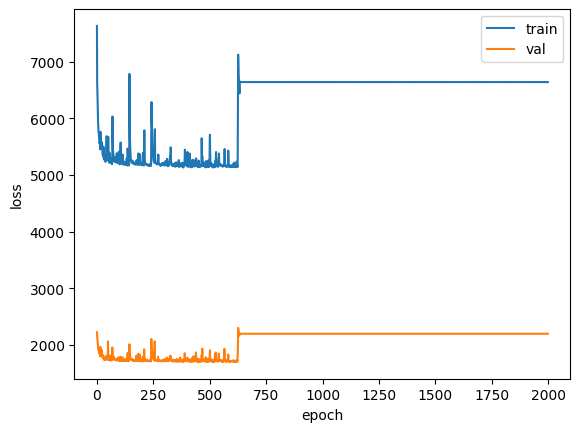

In [7]:
# Let's draw a learning curve like below.
plt.plot(train_loss_history, label='train')
plt.plot(val_loss_history, label='val')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [ ]:
lossF = 'MSE'
layerN = 3
modelt = 'A'
dtype = 'normal'
paramT = 'best_model'

# trained_classifier = Classifier(args.seq_len//(2**args.layer_num)*args.class_num, args.class_num).to(args.device)
encoder.load_state_dict(torch.load(args.checkpoints+f'{modelt}_{dtype}_model_e.pth'))
trained_classifier.load_state_dict(torch.load(args.checkpoints+f'{lossF}_{layerN}L_{modelt}_{dtype}_{paramT}_c.pth'))

<All keys matched successfully>

In [9]:
from sklearn.metrics import roc_auc_score, average_precision_score

for dataT in ['mixed', 'normal']:
    args.data_type = dataT
    # if dataT == 'mixed':
    #     continue
    for modelT in ['model', 'best_model']:
        for lossf in ['MSE', 'CE']:
            encoder.load_state_dict(torch.load(args.checkpoints+f'{args.model}_{args.data_type}_model_e.pth'))
            trained_classifier.load_state_dict(torch.load(args.checkpoints+f'{lossf}_3L_{args.model}_{args.data_type}_{modelT}_c.pth'))

            correct = 0
            total = 0

            with torch.no_grad():
                for inputs, labels in data_loaders["test"]:
                    inputs = inputs.to(args.device)[:,:,:2].type(torch.float32).transpose(1, 2)
                    labels = F.one_hot(labels, num_classes=4).to(args.device).type(torch.float32)

                    hidden = encoder(inputs)
                    outputs = trained_classifier(hidden.reshape(hidden.size(0), -1)).type(torch.float32)
                    
                    total += labels.size(0)
                    correct += (outputs.argmax(1) == labels.argmax(1)).sum().item()
            print(args.data_type, modelT, lossf)
            print('Accuracy:', correct/total * 100, '%')

mixed model MSE
Accuracy: 79.0 %
mixed model CE
Accuracy: 25.0 %
mixed best_model MSE
Accuracy: 95.25 %
mixed best_model CE
Accuracy: 97.0 %
normal model MSE
Accuracy: 25.0 %
normal model CE
Accuracy: 96.0 %
normal best_model MSE
Accuracy: 92.5 %
normal best_model CE
Accuracy: 96.75 %


## 1000 for AE, 2000 for C
### Mixed
3 layer
- MSE: 96
- CE: 96.75

### Normal
3 layer
- MSE: 97.25
- CE: 98.75